## Basic imports

In [ ]:
# Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

from pathlib import Path
import os
import re
import html
import string

import unicodedata


import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer


from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences





[nltk_data] Downloading package punkt to /root/nltk_data...

[nltk_data]   Unzipping tokenizers/punkt.zip.

[nltk_data] Downloading package stopwords to /root/nltk_data...

[nltk_data]   Unzipping corpora/stopwords.zip.

[nltk_data] Downloading package wordnet to /root/nltk_data...




Describe collaborative filtering and its relation to SVD and Matrix factorization

## Learning Objectives
- Learner will be able to extract the user/movie rating matrix from MovieLens dataset using pandas
- Learner will be able to prepare the categorical variables of meta data for MovieLens dataset
- Learner will be able to build a collaborative filter for MovieLens dataset




Extract the user/movie rating matrix from MovieLens dataset using pandas, for the top 15 movies and users.

In [ ]:
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

--2023-12-24 20:25:50--  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152

Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.

HTTP request sent, awaiting response... 200 OK

Length: 978202 (955K) [application/zip]

Saving to: ‘ml-latest-small.zip’



ml-latest-small.zip 100%[===================>] 955.28K  3.03MB/s    in 0.3s    



2023-12-24 20:25:50 (3.03 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]




In [ ]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip

   creating: ml-latest-small/

  inflating: ml-latest-small/links.csv  

  inflating: ml-latest-small/tags.csv  

  inflating: ml-latest-small/ratings.csv  

  inflating: ml-latest-small/README.txt  

  inflating: ml-latest-small/movies.csv  


In [ ]:
movies = pd.read_csv('ml-latest-small/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [26]:
pd.crosstab(ratings.userId, ratings.movieId).head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
k = 15
g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:k]

g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:k]

top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0




Encode the user id, and movie id categorical variables, using sklean LabelEncoder to be used with the Embedding layer.

In [ ]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings.userId.values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = user_enc.fit_transform(ratings.movieId.values)
n_movies = ratings['movie'].nunique()

ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

n_users, n_movies, min_rating, max_rating

(610, 9724, 0.5, 5.0)



Build the collaborative filtering model, using keras Embedding and Dot layers

Model: "model"

__________________________________________________________________________________________________

 Layer (type)                Output Shape                 Param #   Connected to                  


 user_id (InputLayer)        [(None, 1)]                  0         []                            

                                                                                                  

 movie_id (InputLayer)       [(None, 1)]                  0         []                            

                                                                                                  

 user_embedding_LUT (Embedd  (None, 1, 50)                30500     ['user_id[0][0]']             

 ing)                                                                                             

                                                                                                  

 movie_embedding_LUT (Embed  (None, 1, 50)                486200    ['movie_id[0][0

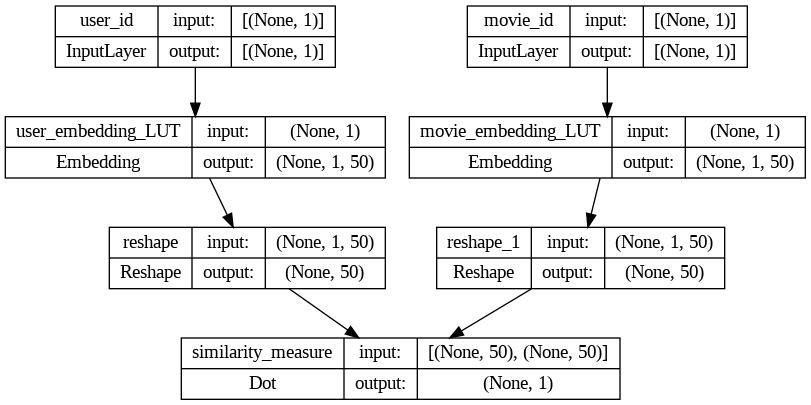

In [ ]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,), name='user_id')
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6), name='user_embedding_LUT')(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# Movie embeddings
movie = layers.Input(shape=(1,), name='movie_id')
movie_emb = layers.Embedding(n_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6), name='movie_embedding_LUT')(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Dot product
rating = layers.Dot(axes=1, name='similarity_measure')([user_emb, movie_emb])


# Model
model = models.Model([user, movie], rating)

# Compile the model
model.compile(loss='mse',  metrics=metrics.RootMeanSquaredError(),
              optimizer=optimizers.Adam(lr=0.001))

# Show model summary
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)


Extract the train and test data for MovieLens

In [ ]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(90752, 2) (90752,)

(10084, 2) (10084,)



Compile and train the model on MovieLens dataset

In [ ]:
# Compile the model
model.compile(loss='mse',  metrics=metrics.RootMeanSquaredError(),
              optimizer=optimizers.Adam(lr=0.001))
model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5

1418/1418 [==============================] - 6s 3ms/step - loss: 9.5344 - root_mean_squared_error: 3.0875 - val_loss: 3.2695 - val_root_mean_squared_error: 1.8067

Epoch 2/5

1418/1418 [==============================] - 5s 4ms/step - loss: 2.0087 - root_mean_squared_error: 1.4145 - val_loss: 1.6440 - val_root_mean_squared_error: 1.2783

Epoch 3/5

1418/1418 [==============================] - 5s 4ms/step - loss: 1.1437 - root_mean_squared_error: 1.0642 - val_loss: 1.3665 - val_root_mean_squared_error: 1.1637

Epoch 4/5

1418/1418 [==============================] - 5s 3ms/step - loss: 0.8878 - root_mean_squared_error: 0.9352 - val_loss: 1.2750 - val_root_mean_squared_error: 1.1229

Epoch 5/5

1418/1418 [==============================] - 5s 4ms/step - loss: 0.7601 - root_mean_squared_error: 0.8634 - val_loss: 1.2426 - val_root_mean_squared_error: 1.1078


In [ ]:
# Assuming 'user_ids' and 'movie_ids' are arrays of user and movie IDs
#predictions = model.predict(X_test)


make predictions on the test set (X_test). Here's a breakdown of what this line is doing:

X_test[:, 0] extracts the user IDs from the test set.
X_test[:, 1] extracts the movie IDs from the test set.
The model.predict method takes these user and movie IDs as input to the trained collaborative filtering model and generates predictions for the corresponding ratings.
The reason for using X_test[:, 0] and X_test[:, 1] is that your model expects two inputs (user and movie IDs) when making predictions. The test set (X_test) likely contains these two columns.

In [ ]:
# Assuming your model is already trained and stored in the 'model' variable

# Use the trained model to predict ratings on the test set
predictions = model.predict([X_test[:, 0], X_test[:, 1]])

# Combine user, movie, and predicted ratings
results = np.column_stack((X_test, predictions))




316/316 [==============================] - 0s 889us/step


In [ ]:
results

array([[4.31000000e+02, 7.31600000e+03, 2.59685755e+00],
       [2.87000000e+02, 4.12000000e+02, 3.41864085e+00],
       [5.98000000e+02, 3.21700000e+03, 3.40932059e+00],
       ...,
       [1.15000000e+02, 5.72100000e+03, 3.25948811e+00],
       [1.10000000e+02, 3.65000000e+03, 2.79807019e+00],
       [4.78000000e+02, 3.09000000e+02, 3.50127506e+00]])

In [ ]:
# Create a DataFrame for better readability
results_df = pd.DataFrame(results, columns=['user', 'movie', 'predicted_rating'])



In [ ]:
results_df.head(3)

,user,movie,predicted_rating
0,431.0,7316.0,2.596858
1,287.0,412.0,3.418641
2,598.0,3217.0,3.409321




In this code:

- The model is used to predict ratings on the test set (`X_test`).
- The results are combined into a DataFrame (`results_df`), which includes columns for user, movie, actual rating, and predicted rating.
- The DataFrame is sorted by user and predicted rating in descending order.
- The `groupby` operation is used to select the top recommendations for each user.
- The top recommendations are displayed, showing the user, movie, and the model's predicted rating.

Adjust the number of recommendations and other parameters according to your specific requirements. This is a basic example, and depending on your use case, you might want to include additional information or post-processing steps to enhance the recommendation results.

For each user, you have the top recommendations sorted by predicted rating in descending order. Users with ID 0.0, 1.0, ..., 609.0 are considered, and for each user, you are showing the top 5 recommendations.

In [ ]:
# Sort by user and predicted rating
results_df.sort_values(['user', 'predicted_rating'], ascending=[True, False], inplace=True)

# Group by user and get top recommendations for each user
top_recommendations = results_df.groupby('user').head(5)  # Adjust '5' to the desired number of recommendations

# Display top recommendations
print("Top Recommendations:")
print(top_recommendations[['user', 'movie', 'predicted_rating']])

Top Recommendations:

       user   movie  predicted_rating

4516    0.0   899.0          5.003855

117     0.0  2794.0          4.951613

2294    0.0  1542.0          4.900981

8251    0.0  2252.0          4.823967

941     0.0   976.0          4.788095

...     ...     ...               ...

6402  609.0  8256.0          5.073995

2690  609.0  5324.0          4.947842

5487  609.0  3979.0          4.927004

2915  609.0   939.0          4.908871

9095  609.0  7439.0          4.892300



[2542 rows x 3 columns]


To Know the movies title ,or name of user if need merge the df top recommand to the old dataframe

In [ ]:
# Assuming you have DataFrames 'users_df' and 'movies_df' with columns 'user_id'/'movie_id' and 'name'/'title'

# Merge with user information
#top_recommendations = pd.merge(top_recommendations, users_df, left_on='user', right_on='user_id', how='left')

# Merge with movie information
top_recommendations = pd.merge(top_recommendations, movies, left_on='movie', right_on='movieId', how='left')

# Display top recommendations with user and movie names/titles
print("Top Recommendations:")
print(top_recommendations[['user',  'movie', 'title', 'predicted_rating']])


Top Recommendations:

       user   movie                                              title  \

0       0.0   899.0                         Singin' in the Rain (1952)   

1       0.0  2794.0  European Vacation (aka National Lampoon's Euro...   

2       0.0  1542.0                                 Brassed Off (1996)   

3       0.0  2252.0                                        Hero (1992)   

4       0.0   976.0                         Farewell to Arms, A (1932)   

...     ...     ...                                                ...   

2537  609.0  8256.0                                                NaN   

2538  609.0  5324.0                   Life or Something Like It (2002)   

2539  609.0  3979.0                                Little Nicky (2000)   

2540  609.0   939.0                                                NaN   

2541  609.0  7439.0                               Punisher, The (2004)   



      predicted_rating  

0             5.003855  

1             4.951613  